# Neural Networks for Data Science Applications
## Second Homework: Experimenting with modularity in deep learning

**Name**: Christian Buda

> ✍ Upload the completed notebook **at least two days prior** to the exam's date on Google Classroom. For example, for the January call (25/01/2023), the final deadline is **23/01/2023 at 23:59** (GMT+1).

**Overview**: The homework is composed of three parts: (i) selecting a dataset and training a standard neural network (<ins>4 points</ins>); (ii) implementing a modular architecture (either an early-exit model or a mixture-of-experts model) and testing it (<ins>6 points</ins>); (iii) implementing a load balancing regularization (ONLY if you did not upload the 1st homework or if you want to improve your mark, </ins>5 points</ins>).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: like for the first homework, this must be done fully in TensorFlow and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

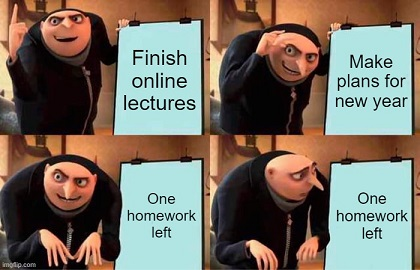

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from data_preprocessing import data_loading

labels = ['Fire', 'Rain', 'Thunderstorm', 'WaterDrops', 'Wind',
          'Silence', 'TreeFalling', 'Helicopter', 'VehicleEngine',
          'Axe', 'Chainsaw', 'Generator', 'Handsaw', 'Firework', 'Gunshot',
          'WoodChop', 'Whistling', 'Speaking', 'Footsteps', 'Clapping', 'Insect',
          'Frog', 'BirdChirping', 'WingFlaping', 'Lion', 'WolfHowl', 'Squirrel']

### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts, graphs)...

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark (with few exceptions, see below), so you can select a complexity that you believe adequate to your skills.

🟩 **Please do:**

1. Provide a complete description of the dataset and the task below.
2. You are not limited to classification tasks. However, tasks that were not seen during the course (e.g., segmentation) **must be thoroughly explained in the text**.
3. Data preprocessing should be done as much as possible in `tf.data`.

🟥 **Please don't:**

1. Absolutely do not use datasets that were seen during our lab sessions.
2. Do not use MNIST, CIFAR-10, CIFAR-100, or any simple variation (e.g., Fashion MNIST).

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

This Kaggle [dataset](https://www.kaggle.com/datasets/irmiot22/fsc22-dataset) includes 2025 labelled sound clips for forest environmental sound classification. The clips are 5s long and are equally distributed between the following 27 classes (labelled from $0$ to $26$):


> Fire, Rain, Thunderstorm, WaterDrops, Wind, Silence, TreeFalling, Helicopter, VehicleEngine, Axe, Chainsaw, Generator, Handsaw, Firework, Gunshot, WoodChop, Whistling, Speaking, Footsteps, Clapping, Insect, Frog, BirdChirping, WingFlaping, Lion, WolfHowl, Squirrel

Spectrograms with various parameters were computed, but in the end the same spectrograms used in the pretrained [YAMNet](https://tfhub.dev/google/yamnet/1) model were chosen as features (as they seem to work better).
The native sampling rate of the files is not fixed, so they have been resampled at $16000$ Hz to be fed to YAMNet. The final dataset element is composed of $528\times 64$ matrices.

The data is equally split between the classes into 3 sets:
* **training:** 1485 samples, used to train the main model
* **validation:** 405 samples, unused in this section
* **test:** 135 samples, used for the early stopping and performance evaluation

In [ ]:
# TODO: Insert any data loading code here. If the data loading part is complex,
# consider using a separate .py file that you can attach to the submission.



# --------------- UPLOAD THE kaggle.json TOKEN HERE ---------------
train_data, val_data, test_data = data_loading()                   # takes more than 10 minutes

Please upload the kaggle.json file.


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


### Exercise 1: Train on your data (4 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. You are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

🟧 You will have to modify this model for Exercise 2, so consider carefully your choice here.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of (i) the model, (ii) the task, (iii) any notable features of your training process.*

**TODO**: add description here (1-2 paragraphs).

The model, just like YAMnet, is inspired by the [MobileNet](https://arxiv.org/abs/1704.04861) architecture and, as such, it contains various Depthwise-Separable Convolutional layers. A residual connection was added before the final dense layer and batch normalization is applied after every convolutional layer.

As described above, the task consists in classifying the audio samples into one of $27$ classes.


In [ ]:
class ConvBlock(tf.keras.layers.Layer):
  # simple convolutional block with layer normalization and max pooling
  def __init__(self, n_filters, kernel_size, pool_size):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(n_filters, kernel_size, padding='same',kernel_regularizer=tf.keras.regularizers.L2(10e-3))
    self.BN = tf.keras.layers.BatchNormalization()
    self.pool = tf.keras.layers.MaxPool2D(pool_size)

  def call(self, inputs, training = None):
    x = self.conv(inputs)
    x = self.BN(x, training = training)
    x = tf.nn.relu(x)
    return self.pool(x)


class DepthwiseSepBlock(tf.keras.layers.Layer):
  # depthwise separable convolutional block with layer normalization and max pooling
  def __init__(self, n_filters, kernel_size, pool_size):
    super().__init__()
    self.Dconv = tf.keras.layers.DepthwiseConv2D(kernel_size, padding='same',kernel_regularizer=tf.keras.regularizers.L2(10e-3))
    self.BN1 = tf.keras.layers.BatchNormalization()
    self.BN2 = tf.keras.layers.BatchNormalization()
    self.pool = tf.keras.layers.MaxPool2D(pool_size)
    self.conv = tf.keras.layers.Conv2D(n_filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.L2(10e-3))

  def call(self, inputs, training = None):
    x = self.Dconv(inputs)
    x = self.BN1(x, training = training)
    x = self.pool(x)
    x = tf.nn.relu(x)
    x = self.conv(x)
    x = self.BN2(x, training = training)
    return tf.nn.relu(x)


class SimpleCNN(tf.keras.Model):
  # the model
  def __init__(self, num_classes=27):
    super().__init__()
    self.block_1 = ConvBlock(32, (5,3), (2,1))                     
    self.block_2 = DepthwiseSepBlock(32, (5,3), (1,1))                     
    self.block_3 = DepthwiseSepBlock(64, (5,3), (2,1))        
    self.block_4 = DepthwiseSepBlock(64, (3,3), (1,1))    
    self.block_5 = DepthwiseSepBlock(128, (3,3), (2,1))             
    self.block_6 = DepthwiseSepBlock(128, (3,3), 1)   
    self.block_7 = DepthwiseSepBlock(128, (3,3), 2)
    self.block_8 = DepthwiseSepBlock(128, (3,3), 1)
    self.block_9 = DepthwiseSepBlock(128, (3,3), 2)                        
    self.block_10 = DepthwiseSepBlock(128, (3,3), 1)                        
    self.block_11 = DepthwiseSepBlock(128, (3,3), 1)  
    self.block_12 = DepthwiseSepBlock(256, (3,3), 2)  
    self.block_13 = DepthwiseSepBlock(256, (3,3), 1)
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dense = tf.keras.layers.Dense(64, activation='relu')  
    self.dp = tf.keras.layers.Dropout(0.3)
    self.classifier = tf.keras.layers.Dense(num_classes)       
    self.res_conv = tf.keras.layers.Conv2D(256, 1, padding='same',kernel_regularizer=tf.keras.regularizers.L2(10e-3))
    self.res_pool = tf.keras.layers.GlobalAveragePooling2D()

  def call(self, inputs, training = None):
    # starting convolutional block
    x = self.block_1(inputs, training = training)                            #(None, 264, 64, 32)

    # depthwise separable convolutional blocks
    x = self.block_2(x, training = training)                                 #(None, 264, 64, 32)
    x = self.block_3(x, training = training)                                 #(None, 132, 64, 64)
    x = self.block_4(x, training = training)                                 #(None, 132, 64, 64)
    x = self.block_5(x, training = training)                                 #(None, 66, 64, 128)
    x = self.block_6(x, training = training)                                 #(None, 66, 64, 128)
    x = self.block_7(x, training = training)                                 #(None, 33, 32, 128)
    x = self.block_8(x, training = training)                                 #(None, 33, 32, 128)
    x = self.block_9(x, training = training)                                 #(None, 16, 16, 128)
    x = self.block_10(x, training = training)                                #(None, 16, 16, 128)
    x = self.block_11(x, training = training)                                #(None, 16, 16, 128)
    x = self.block_12(x, training = training)                                #(None, 8, 8, 256)
    x = self.block_13(x, training = training)                                #(None, 8, 8, 256)

    x = self.global_pool(x)                                                  #(None, 256)

    # residual connection
    int_x = self.res_conv(inputs)   # 1x1 conv
    int_x = self.res_pool(int_x)    # avgPool

    x = self.dense(x+int_x)                                                  #(None, 64)
    x = self.dp(x, training = training)
    x = self.classifier(x)                                                   #(None, 27)
    return(x)

In [ ]:
for xb, yb in train_data:
  break
xb.shape

TensorShape([48, 528, 64, 1])

In [ ]:
cbs = [
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=17, 
                            restore_best_weights=True, verbose=1, start_from_epoch = 30)
]

In [ ]:
# TODO: add the model definition and model training code here (as many cells as you need).
stock_model = SimpleCNN()
stock_model(xb).shape

TensorShape([48, 27])

In [ ]:
stock_model.summary()

Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block (ConvBlock)      multiple                  640       
                                                                 
 depthwise_sep_block (Depthw  multiple                 1824      
 iseSepBlock)                                                    
                                                                 
 depthwise_sep_block_1 (Dept  multiple                 3008      
 hwiseSepBlock)                                                  
                                                                 
 depthwise_sep_block_2 (Dept  multiple                 5312      
 hwiseSepBlock)                                                  
                                                                 
 depthwise_sep_block_3 (Dept  multiple                 9728      
 hwiseSepBlock)                                         

In [ ]:
stock_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
# You can train using fit() or a custom training loop, equivalently.
history_stock = stock_model.fit(train_data, validation_data=test_data, epochs=1000, callbacks=cbs)

Epoch 1/1000
31/31 [==============================] - 38s 557ms/step - loss: 15.8627 - sparse_categorical_accuracy: 0.0680 - val_loss: 14.3873 - val_sparse_categorical_accuracy: 0.0370
Epoch 2/1000
31/31 [==============================] - 12s 381ms/step - loss: 12.9147 - sparse_categorical_accuracy: 0.1488 - val_loss: 12.1964 - val_sparse_categorical_accuracy: 0.0444
Epoch 3/1000
31/31 [==============================] - 11s 367ms/step - loss: 10.9075 - sparse_categorical_accuracy: 0.1973 - val_loss: 10.7269 - val_sparse_categorical_accuracy: 0.0667
Epoch 4/1000
31/31 [==============================] - 11s 371ms/step - loss: 9.4609 - sparse_categorical_accuracy: 0.2606 - val_loss: 9.6901 - val_sparse_categorical_accuracy: 0.0593
Epoch 5/1000
31/31 [==============================] - 11s 366ms/step - loss: 8.3703 - sparse_categorical_accuracy: 0.3077 - val_loss: 8.9321 - val_sparse_categorical_accuracy: 0.0370
Epoch 6/1000
31/31 [==============================] - 11s 367ms/step - loss: 7.

✍ **RESULTS**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly. Explain them in code or in text, equivalently.*

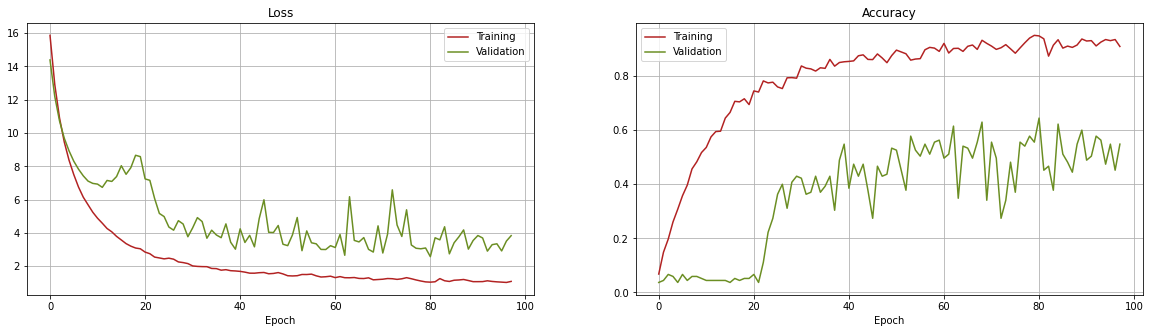

In [ ]:
# make some plots
fig,ax = plt.subplots(1,2, figsize = (20,5))

epochs = np.arange(len(history_stock.history['loss']))
ax[0].plot(epochs, history_stock.history['loss'], label = 'Training', color = 'firebrick')
ax[0].plot(epochs, history_stock.history['val_loss'], label = 'Validation', color = 'olivedrab')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].grid()
ax[1].plot(epochs, history_stock.history['sparse_categorical_accuracy'], label = 'Training', color = 'firebrick')
ax[1].plot(epochs, history_stock.history['val_sparse_categorical_accuracy'], label = 'Validation', color = 'olivedrab')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].grid()
plt.show()

5/5 [==============================] - 0s 68ms/step


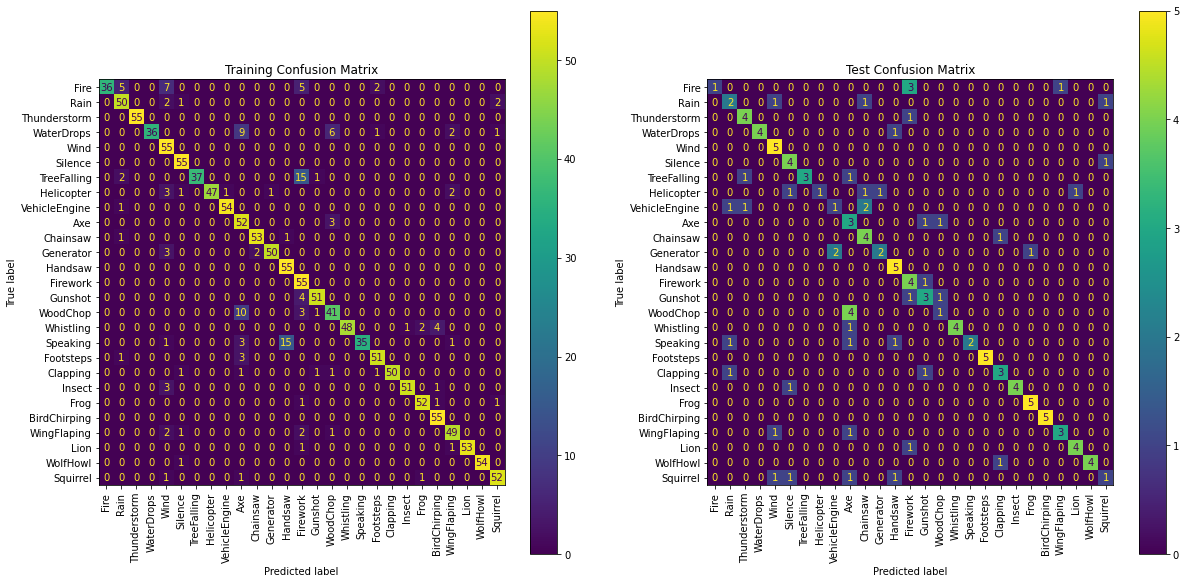

In [ ]:
X_test, y_test = test_data.unbatch().batch(3000).get_single_element()
X_train, y_train = train_data.unbatch().batch(3000).get_single_element()

fig,ax = plt.subplots(1,2, figsize = (20,10))

actual = y_train
predicted = tf.argmax(stock_model.predict(X_train), -1)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, ax = ax[0])
ax[0].set_xticklabels(labels, rotation = 90)
ax[0].set_yticklabels(labels, rotation = 0)
ax[0].set_title('Training Confusion Matrix')


actual = y_test
predicted = tf.argmax(stock_model.predict(X_test), -1)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, ax = ax[1])
ax[1].set_xticklabels(labels, rotation = 90)
ax[1].set_yticklabels(labels, rotation = 0)
ax[1].set_title('Test Confusion Matrix')


plt.show()

In [ ]:
train_loss, train_acc = stock_model.evaluate(train_data)
val_loss, val_acc = stock_model.evaluate(test_data)

print(f'Training loss is {train_loss:.2f}\nValidation loss is {val_loss:.2f}\nTrain accuracy is {train_acc:.2f}\nTest accuracy is {val_acc:.2f}')

5/5 [==============================] - 0s 61ms/step - loss: 2.5762 - sparse_categorical_accuracy: 0.6444
Training loss is 1.21
Validation loss is 2.58
Train accuracy is 0.90
Test accuracy is 0.64


As we can see from the plots above, both the loss and the accuracy in test became stable after about 30 epochs. Training accuracy is $89\%$, while test accuracy peaked at about $64\%$.

As we can see in the training confusion matrix, the WoodChop class gets easily confused with the Axe class (this was a constant across the various different training instances) and, notably, the TreeFalling class gets confused with the Firework class (understandable, since some of these classes could be ambiguos to a human too).

From the test confusion matrix we can see again the WoodChop class mistaken as Axe noise.

It should be noted that the limitation here is in the size of the dataset and the splits themselves, since it was observed that the model is able to reach almost $100%$ accuracy in training and up to $80%$ accuracy in test with a more balanced train-test split.

### Exercise 2 (6 points): Adding modularity to the network

The purpose of this second exercise is to implement a "modular" network, in the sense we discussed in class. In particular, two variants are allowed for this exercise (<ins>only one variant should be implemented</ins>):

1.   **Variant 2a, Early-exits**: Modify the model in Exercise 1 by adding 2 or more early exits and train it.
2.   **Variant 2b, Mixture-of-experts**: Modify the model in Exercise 1 by replacing at least one layer of the model with a MoE layer.

🟩 You are free to design the model as much as you want: you can follow the slides directly (e.g., summing the losses of all early exits during training), or you can follow some of the bibliographic references in the slides, or even any other paper you find online (e.g., the MoE model may route single tokens, entire images, with different routing mechanisms, etc.).

🟥 **Please don't:**

1. Copy-paste from the web (immediate zero mark).

✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the model (what you implemented, bibliographic references, how you are training it, notable implementation issues, etc.).*

**TODO**: add a complete description here (2-3 paragraphs).

Starting on the model showed before, four early exit were added in various points of the network. To add an early exit, a simple classifier with a depthwise separable convolution and a global pooling was inserted inside the already existing network.

Another small network, the "Exit Organizer" (composed by a convolutional block, followed by a dense and a classifier layer), was used in order to decide which exit should be taken by each element.

A simple masking logic was implemented in order to allow batched data into the network: a final output tensor was initialized and updated at each exit, and the elements that exited are removed from the network pipeline as soon as they reach their designated exit.

Finally, a differentiable sampling mechanism (that uses the Gumbel-Softmax trick) was used to insert randomicity into the exit choice, and the STE was used to allow backpropagation through the organizer.

The network as described above could, at least in principle, be trained all at once, but in practice it turned out impossibile to train. Something in the organizer (independent from the sampling mechanism) introduced NaNs in the training procedure for some instances of the inizializations. Identifying the cause of this problem turned out too hard, so a different training strategy was implemented:
* The network was manually split into five incrementally big networks (one for each exit, with the last one being the full model without the organizer) with just a final exit.
* Each model adds something to the previous one; these additional layers are initialized using the stock model weights, while the layers trained in the previous exit are frozen and match the trained weights of the smaller model in the chain.
* Finally, the trained layers and exit are inserted in the full Early Exit model described above; these weights are frozen and this network is fitted to the validation data to allow the organizer to learn the correct exit for each sample.
* To prevent the organizer to always choose the highest accuracy exit, a simple load balancing technique was implemented (a KL-divergence term was added to the cross-entropy to create the final loss function).
* The Exit Organizer turned out really hard to train properly: different load balancing distributions were used and a temperature term was added to the organizer output to prevent the Organizer to promote slight overconfidence (to better simulate an hard choice in the exit); none of this was enough to properly execute training.

As a summary, the data in this section is used in this way:
* **training:** used to train the five exits
* **validation:** used to train the organizer (to allow it to learn using a proper estimate of the accuracy of each exit)
* **test:** used for the early stopping and performance evaluation

In [ ]:
# TODO: add all code here, using as many cells as you need. Train the new model.

In [ ]:
# useful layers (some repeated for convenience)

class ConvBlock(tf.keras.layers.Layer):
  # simple convolutional block with layer normalization and max pooling
  def __init__(self, n_filters, kernel_size, pool_size):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(n_filters, kernel_size, padding='same',kernel_regularizer=tf.keras.regularizers.L2(10e-3))
    self.BN = tf.keras.layers.BatchNormalization()
    self.pool = tf.keras.layers.MaxPool2D(pool_size)

  def call(self, inputs, training = None):
    x = self.conv(inputs)
    x = self.BN(x, training = training)
    x = tf.nn.relu(x)
    return self.pool(x)


class DepthwiseSepBlock(tf.keras.layers.Layer):
  # depthwise separable convolutional block with layer normalization and max pooling
  def __init__(self, n_filters, kernel_size, pool_size):
    super().__init__()
    self.Dconv = tf.keras.layers.DepthwiseConv2D(kernel_size, padding='same',kernel_regularizer=tf.keras.regularizers.L2(10e-3))
    self.BN1 = tf.keras.layers.BatchNormalization()
    self.BN2 = tf.keras.layers.BatchNormalization()
    self.pool = tf.keras.layers.MaxPool2D(pool_size)
    self.conv = tf.keras.layers.Conv2D(n_filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.L2(10e-3))

  def call(self, inputs, training = None):
    x = self.Dconv(inputs)
    x = self.BN1(x, training = training)
    x = self.pool(x)
    x = tf.nn.relu(x)
    x = self.conv(x)
    x = self.BN2(x, training = training)
    return tf.nn.relu(x)


class EarlyExitClassifier(tf.keras.layers.Layer):
  # quick classifier to perform the early exit
  def __init__(self, n_filters, kernel_size, num_classes):
    super().__init__()
    self.conv_block = DepthwiseSepBlock(n_filters, kernel_size, 1)
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.classifier = tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.L2(10e-3))

  def call(self, inputs, training = None):
    exit = self.conv_block(inputs, training = training)
    exit = self.global_pool(exit)
    exit = self.classifier(exit)
    return exit


class EarlyExit(tf.keras.layers.Layer):
 # layer that implements the logic for the early exit
 def __init__(self, num_exits, exiters):
   super().__init__()
   self.current_exit = -1
   self.num_exits = num_exits
   self.where_to_exit = tf.zeros(())
   self.what_goes_on = tf.zeros(())
   self.outputs = tf.zeros(())
   self.exiters = exiters
  
 def restart(self, where_to_exit, outputs):
   self.where_to_exit = where_to_exit
   self.what_goes_on = where_to_exit
   self.outputs = outputs
   self.current_exit = -1
   
 def call(self, x, training = None):
   self.current_exit += 1
   which_elements = tf.math.equal(self.what_goes_on,self.current_exit)                 # which elements exit here
   where_to_go = tf.squeeze(tf.where(which_elements), axis = 1)                        # the indices of the elements that need to exit
   what_to_take = tf.gather(x, indices = where_to_go, batch_dims = 1, axis = 0)        # the elements that need to exit
   exit_out = self.exiters[self.current_exit](what_to_take, training = training)       # the result for the elements that exited
  
   # update the output tensor
   indices = tf.where(tf.math.equal(self.where_to_exit,self.current_exit))
   self.outputs = tf.tensor_scatter_nd_update(self.outputs, indices, exit_out) 

   where_to_go = tf.squeeze(tf.where(tf.math.logical_not(which_elements)), axis = 1)   # which elements did not exit
   x = tf.gather(x, indices = where_to_go, batch_dims = 1, axis = 0)                   # the elements that need to go on
   self.what_goes_on = tf.gather(self.what_goes_on, indices = where_to_go)             # remove previous exit from the list
   return x


class ExitOrganizer(tf.keras.layers.Layer):
  # classifier layer to choose where to exit beforehand
  def __init__(self, num_exits, temperature = 1):
    super().__init__()
    self.temperature = temperature
    self.conv_block = tf.keras.layers.Conv2D(96, 1, padding='same',kernel_regularizer=tf.keras.regularizers.L2(10e-3))   
    self.global_pool = tf.keras.layers.GlobalMaxPool2D()
    self.dense = tf.keras.layers.Dense(48, kernel_regularizer=tf.keras.regularizers.L2(10e-3))
    self.dp = tf.keras.layers.Dropout(0.2)
    self.classifier = tf.keras.layers.Dense(num_exits, kernel_regularizer=tf.keras.regularizers.L2(10e-3))
    self.gumbel = tfp.distributions.Gumbel(0, 1)

  def call(self, inputs, training = None):
    x = self.conv_block(inputs, training = training)     #(None, 132, 64, 48)
    x = self.global_pool(x)                              #(None, 96)
    x = self.dense(x)                                    #(None, 48)
    x = self.dp(x, training = training)
    x = self.classifier(x)                               #(None, num_exits)
    if training:
      # sample exits
      sampled_x = ( tf.nn.log_softmax(x) + self.gumbel.sample( tf.shape(x) ) )
      return tf.nn.softmax(x/self.temperature), tf.nn.softmax(sampled_x/self.temperature)
    exits = tf.nn.softmax(x)
    return exits, exits

class LoadBalancingLoss(tf.keras.losses.Loss):
  # KL divergence term for load balancing
  def __init__(self, balancing_distr, alpha = 1):
    super().__init__()
    self.balancing_distr = balancing_distr
    self.kl = tf.keras.losses.KLDivergence()

  def call(self, y_true, exits):
    return self.kl(self.balancing_distr, exits)

In [ ]:
class EarlyExitCNN(tf.keras.Model):
  # the complete early exit model
  def __init__(self, num_classes=27, temperature = 1):
    super().__init__()
    # parameters
    self.temperature = temperature
    self.num_classes = num_classes
    self.num_exits = 5
    # exit organizer
    self.organizer = ExitOrganizer(self.num_exits, temperature = self.temperature)
    # main network
    self.block_1 = ConvBlock(32, (5,3), (2,1))                    
    self.block_2 = DepthwiseSepBlock(32, (5,3), (1,1))                   
    self.block_3 = DepthwiseSepBlock(64, (5,3), (2,1))        
    self.block_4 = DepthwiseSepBlock(64, (3,3), (1,1))    
    self.block_5 = DepthwiseSepBlock(128, (3,3), (2,1))             
    self.block_6 = DepthwiseSepBlock(128, (3,3), 1)   
    self.block_7 = DepthwiseSepBlock(128, (3,3), 2)
    self.block_8 = DepthwiseSepBlock(128, (3,3), 1)     
    self.block_9 = DepthwiseSepBlock(128, (3,3), 2)                        
    self.block_10 = DepthwiseSepBlock(128, (3,3), 1)                        
    self.block_11 = DepthwiseSepBlock(128, (3,3), 1)  
    self.block_12 = DepthwiseSepBlock(256, (3,3), 2)  
    self.block_13 = DepthwiseSepBlock(256, (3,3), 1)
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dense = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(10e-3))  
    self.dp = tf.keras.layers.Dropout(0.3)
    self.classifier = tf.keras.layers.Dense(self.num_classes, kernel_regularizer=tf.keras.regularizers.L2(10e-3))       
    self.res_conv = tf.keras.layers.Conv2D(256, 1, padding='same',kernel_regularizer=tf.keras.regularizers.L2(10e-3))
    self.res_pool = tf.keras.layers.GlobalAveragePooling2D()
    # exit classifiers
    self.exit_classifier_0 = EarlyExitClassifier(32, (5,3), self.num_classes)
    self.exit_classifier_1 = EarlyExitClassifier(64, (5,3), self.num_classes)
    self.exit_classifier_2 = EarlyExitClassifier(128, (3,3), self.num_classes)
    self.exit_classifier_3 = EarlyExitClassifier(128, (3,3), self.num_classes)
    # early exit logic layer
    self.early_exit = EarlyExit(self.num_exits, [self.exit_classifier_0, self.exit_classifier_1, self.exit_classifier_2, self.exit_classifier_3])

  def choose_exits(self, inputs, training = False):
    return(tf.argmax(self.organizer(inputs, training = training)[1], axis = 1))

  def call(self, inputs, training = None):
    # output tensor with prediction for each element
    outputs = tf.zeros((tf.shape(inputs)[0], self.num_classes))              #(None, num_classes)

    # choose where to exit
    exits, soft_sample = self.organizer(inputs, training = training)         #(None, num_exits)
    where_to_exit = tf.stop_gradient(tf.argmax(soft_sample, axis = -1))      #(None,)

    # restart the early exit logic
    self.early_exit.restart(where_to_exit, outputs)
    #tf.print('\nUscite',where_to_exit, summarize = -1)  # debugging

    # starting convolutional block
    x = self.block_1(inputs, training = training)                            #(None, 264, 64, 32)
    # depthwise separable convolutional blocks
    x = self.block_2(x, training = training)                                 #(None, 264, 64, 32)
    x = self.early_exit(x, training = training)                              # early exit 0      ##################### EXIT #####################
    x = self.block_3(x, training = training)                                 #(None, 132, 64, 64)
    x = self.block_4(x, training = training)                                 #(None, 132, 64, 64)
    x = self.early_exit(x, training = training)                              # early exit 1      ##################### EXIT #####################
    x = self.block_5(x, training = training)                                 #(None, 66, 64, 128)
    x = self.block_6(x, training = training)                                 #(None, 66, 64, 128)
    x = self.block_7(x, training = training)                                 #(None, 33, 32, 128)
    x = self.block_8(x, training = training)                                 #(None, 33, 32, 128)
    x = self.early_exit(x, training = training)                              # early exit 2      ##################### EXIT #####################
    x = self.block_9(x, training = training)                                 #(None, 16, 16, 128)
    x = self.block_10(x, training = training)                                #(None, 16, 16, 128)
    x = self.block_11(x, training = training)                                #(None, 16, 16, 128)
    x = self.early_exit(x, training = training)                              # early exit 3      ##################### EXIT #####################
    x = self.block_12(x, training = training)                                #(None, 8, 8, 256)
    x = self.block_13(x, training = training)                                #(None, 8, 8, 256)
    x = self.global_pool(x)                                                  #(None, 256)
    # --------------------------------------------------------------------------------------------
    # final exit, done manually because of the residual connection
    current_exit = 4

    which_elements = tf.math.equal(where_to_exit,current_exit)                                              # which elements exit here
    where_to_go = tf.where(which_elements)                                                                  # the indices of the elements that need to exit
    what_to_take = tf.gather(inputs, indices = tf.squeeze(where_to_go, axis = 1), batch_dims = 1, axis = 0) # the elements that need to exit

    # residual connection
    int_x = self.res_conv(what_to_take)   # 1x1 conv
    int_x = self.res_pool(int_x)          # avgPool

    # final classification block
    x = self.dense(x+int_x)                                                  #(None, 64)
    x = self.dp(x, training = training)
    x = self.classifier(x)                                                   #(None, 27)

    # update the exit tensor
    self.early_exit.outputs = tf.tensor_scatter_nd_update(self.early_exit.outputs, indices = where_to_go, updates = x)
    # --------------------------------------------------------------------------------------------
    # multiply by the confidence of the chosen exit to allow backpropagation to the organizer
    outputs = self.early_exit.outputs * tf.expand_dims(tf.reduce_max(soft_sample, axis = 1), axis = -1)

    # STE approach
    # onehot_load = tf.stop_gradient(tf.one_hot(tf.argmax(exits, axis = -1), self.num_exits))
    #exits = onehot_load - tf.stop_gradient(exits) + exits

    # smooth estimate for the average load of each exit
    exit_load = tf.expand_dims(tf.reduce_mean(exits, axis = 0), axis = 0)
    # tf.print('\nuscite', exits, '\nload',exit_load)    # debug
    return([outputs, exit_load])

class Exit0CNN(tf.keras.Model):
  def __init__(self, num_classes=27):
    super().__init__()
    # parameters
    self.num_classes = num_classes
    # main network
    self.block_1 = ConvBlock(32, (5,3), (2,1))                    
    self.block_2 = DepthwiseSepBlock(32, (5,3), (1,1))                   
    # exit classifier
    self.exit_classifier_0 = EarlyExitClassifier(32, (5,3), self.num_classes)

  def call(self, inputs, training = None):
    # starting convolutional block
    x = self.block_1(inputs, training = training)                            #(None, 264, 64, 32)
    # depthwise separable convolutional blocks
    x = self.block_2(x, training = training)                                 #(None, 264, 64, 32)
    # exit 0--------------------------------------------------------------------------------------
    exit_out = self.exit_classifier_0(x, training = training)        # the result for the elements that exited
    # --------------------------------------------------------------------------------------------
    return(exit_out)

class Exit1CNN(tf.keras.Model):
  def __init__(self, num_classes=27):
    super().__init__()
    # parameters
    self.num_classes = num_classes
    # main network
    self.block_1 = ConvBlock(32, (5,3), (2,1))                    
    self.block_2 = DepthwiseSepBlock(32, (5,3), (1,1))                   
    self.block_3 = DepthwiseSepBlock(64, (5,3), (2,1))        
    self.block_4 = DepthwiseSepBlock(64, (3,3), (1,1))    
    # exit classifier
    self.exit_classifier_1 = EarlyExitClassifier(64, (5,3), self.num_classes)

  def call(self, inputs, training = None):
    # starting convolutional block
    x = self.block_1(inputs, training = training)                            #(None, 264, 64, 32)
    # depthwise separable convolutional blocks
    x = self.block_2(x, training = training)                                 #(None, 264, 64, 32)
    x = self.block_3(x, training = training)                                 #(None, 132, 64, 64)
    x = self.block_4(x, training = training)                                 #(None, 132, 64, 64)
    # exit 1--------------------------------------------------------------------------------------
    exit_out = self.exit_classifier_1(x, training = training)        # the result for the elements that exited
    # --------------------------------------------------------------------------------------------
    return(exit_out)

class Exit2CNN(tf.keras.Model):
  def __init__(self, num_classes=27):
    super().__init__()
    # parameters
    self.num_classes = num_classes
    # main network
    self.block_1 = ConvBlock(32, (5,3), (2,1))                    
    self.block_2 = DepthwiseSepBlock(32, (5,3), (1,1))                   
    self.block_3 = DepthwiseSepBlock(64, (5,3), (2,1))        
    self.block_4 = DepthwiseSepBlock(64, (3,3), (1,1))    
    self.block_5 = DepthwiseSepBlock(128, (3,3), (2,1))             
    self.block_6 = DepthwiseSepBlock(128, (3,3), 1)   
    self.block_7 = DepthwiseSepBlock(128, (3,3), 2)
    self.block_8 = DepthwiseSepBlock(128, (3,3), 1)     
    # exit classifiers
    self.exit_classifier_2 = EarlyExitClassifier(128, (3,3), self.num_classes)

  def call(self, inputs, training = None):
    # starting convolutional block
    x = self.block_1(inputs, training = training)                            #(None, 264, 64, 32)
    # depthwise separable convolutional blocks
    x = self.block_2(x, training = training)                                 #(None, 264, 64, 32)
    x = self.block_3(x, training = training)                                 #(None, 132, 64, 64)
    x = self.block_4(x, training = training)                                 #(None, 132, 64, 64)
    x = self.block_5(x, training = training)                                 #(None, 66, 64, 128)
    x = self.block_6(x, training = training)                                 #(None, 66, 64, 128)
    x = self.block_7(x, training = training)                                 #(None, 33, 32, 128)
    x = self.block_8(x, training = training)                                 #(None, 33, 32, 128)
    # exit 2--------------------------------------------------------------------------------------
    exit_out = self.exit_classifier_2(x, training = training)        # the result for the elements that exited
    # --------------------------------------------------------------------------------------------
    return(exit_out)

class Exit3CNN(tf.keras.Model):
  def __init__(self, num_classes=27):
    super().__init__()
    # parameters
    self.num_classes = num_classes
    # main network
    self.block_1 = ConvBlock(32, (5,3), (2,1))                    
    self.block_2 = DepthwiseSepBlock(32, (5,3), (1,1))                   
    self.block_3 = DepthwiseSepBlock(64, (5,3), (2,1))        
    self.block_4 = DepthwiseSepBlock(64, (3,3), (1,1))    
    self.block_5 = DepthwiseSepBlock(128, (3,3), (2,1))             
    self.block_6 = DepthwiseSepBlock(128, (3,3), 1)   
    self.block_7 = DepthwiseSepBlock(128, (3,3), 2)
    self.block_8 = DepthwiseSepBlock(128, (3,3), 1)     
    self.block_9 = DepthwiseSepBlock(128, (3,3), 2)                        
    self.block_10 = DepthwiseSepBlock(128, (3,3), 1)                        
    self.block_11 = DepthwiseSepBlock(128, (3,3), 1)  
    # exit classifiers
    self.exit_classifier_3 = EarlyExitClassifier(128, (3,3), self.num_classes)

  def call(self, inputs, training = None):
    # starting convolutional block
    x = self.block_1(inputs, training = training)                            #(None, 264, 64, 32)
    # depthwise separable convolutional blocks
    x = self.block_2(x, training = training)                                 #(None, 264, 64, 32)
    x = self.block_3(x, training = training)                                 #(None, 132, 64, 64)
    x = self.block_4(x, training = training)                                 #(None, 132, 64, 64)
    x = self.block_5(x, training = training)                                 #(None, 66, 64, 128)
    x = self.block_6(x, training = training)                                 #(None, 66, 64, 128)
    x = self.block_7(x, training = training)                                 #(None, 33, 32, 128)
    x = self.block_8(x, training = training)                                 #(None, 33, 32, 128)
    x = self.block_9(x, training = training)                                 #(None, 16, 16, 128)
    x = self.block_10(x, training = training)                                #(None, 16, 16, 128)
    x = self.block_11(x, training = training)                                #(None, 16, 16, 128)
    # exit 3--------------------------------------------------------------------------------------
    exit_out = self.exit_classifier_3(x, training = training)        # the result for the elements that exited
    # --------------------------------------------------------------------------------------------
    return(exit_out)

class Exit4CNN(tf.keras.Model):
  def __init__(self, num_classes=27):
    super().__init__()
    # parameters
    self.num_classes = num_classes
    # main network
    self.block_1 = ConvBlock(32, (5,3), (2,1))                    
    self.block_2 = DepthwiseSepBlock(32, (5,3), (1,1))                   
    self.block_3 = DepthwiseSepBlock(64, (5,3), (2,1))        
    self.block_4 = DepthwiseSepBlock(64, (3,3), (1,1))    
    self.block_5 = DepthwiseSepBlock(128, (3,3), (2,1))             
    self.block_6 = DepthwiseSepBlock(128, (3,3), 1)   
    self.block_7 = DepthwiseSepBlock(128, (3,3), 2)
    self.block_8 = DepthwiseSepBlock(128, (3,3), 1)     
    self.block_9 = DepthwiseSepBlock(128, (3,3), 2)                        
    self.block_10 = DepthwiseSepBlock(128, (3,3), 1)                        
    self.block_11 = DepthwiseSepBlock(128, (3,3), 1)  
    self.block_12 = DepthwiseSepBlock(256, (3,3), 2)  
    self.block_13 = DepthwiseSepBlock(256, (3,3), 1)
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dense = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(10e-3))  
    self.dp = tf.keras.layers.Dropout(0.3)
    self.classifier = tf.keras.layers.Dense(self.num_classes, kernel_regularizer=tf.keras.regularizers.L2(10e-3))       
    self.res_conv = tf.keras.layers.Conv2D(256, 1, padding='same',kernel_regularizer=tf.keras.regularizers.L2(10e-3))
    self.res_pool = tf.keras.layers.GlobalAveragePooling2D()

  def call(self, inputs, training = None):
    # starting convolutional block
    x = self.block_1(inputs, training = training)                            #(None, 264, 64, 32)
    # depthwise separable convolutional blocks
    x = self.block_2(x, training = training)                                 #(None, 264, 64, 32)
    x = self.block_3(x, training = training)                                 #(None, 132, 64, 64)
    x = self.block_4(x, training = training)                                 #(None, 132, 64, 64)
    x = self.block_5(x, training = training)                                 #(None, 66, 64, 128)
    x = self.block_6(x, training = training)                                 #(None, 66, 64, 128)
    x = self.block_7(x, training = training)                                 #(None, 33, 32, 128)
    x = self.block_8(x, training = training)                                 #(None, 33, 32, 128)
    x = self.block_9(x, training = training)                                 #(None, 16, 16, 128)
    x = self.block_10(x, training = training)                                #(None, 16, 16, 128)
    x = self.block_11(x, training = training)                                #(None, 16, 16, 128)
    x = self.block_12(x, training = training)                                #(None, 8, 8, 256)
    x = self.block_13(x, training = training)                                #(None, 8, 8, 256)
    x = self.global_pool(x)                                                  #(None, 256)
    # exit 4--------------------------------------------------------------------------------------
    # residual connection
    int_x = self.res_conv(inputs)   # 1x1 conv
    int_x = self.res_pool(int_x)    # avgPool

    x = self.dense(x+int_x)                                                  #(None, 64)
    x = self.dp(x, training = training)
    exit_out = self.classifier(x)                                                   #(None, 27)
    # --------------------------------------------------------------------------------------------
    return(exit_out)

In [ ]:
for xb,yb in train_data:
  break

cbs = [
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=9,
                            restore_best_weights=True, verbose=1, start_from_epoch = 15),
]

# define and build the 5 models
exit0_model = Exit0CNN()
exit0_model.build(xb.shape)
exit1_model = Exit1CNN()
exit1_model.build(xb.shape)
exit2_model = Exit2CNN()
exit2_model.build(xb.shape)
exit3_model = Exit3CNN()
exit3_model.build(xb.shape)
exit4_model = Exit4CNN()
exit4_model.build(xb.shape)

#### Train Exit 0

In [ ]:
# copy starting parameters from the stock model to (hopefully) speed up training
exit0_model.block_1.set_weights(stock_model.block_1.get_weights())
exit0_model.block_2.set_weights(stock_model.block_2.get_weights())

exit0_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

history_exit0 = exit0_model.fit(train_data, validation_data=test_data, epochs=50, callbacks=cbs)

Epoch 1/50
31/31 [==============================] - 7s 124ms/step - loss: 3.9280 - sparse_categorical_accuracy: 0.0640 - val_loss: 3.8828 - val_sparse_categorical_accuracy: 0.0667
Epoch 2/50
31/31 [==============================] - 4s 114ms/step - loss: 3.6953 - sparse_categorical_accuracy: 0.0882 - val_loss: 3.7731 - val_sparse_categorical_accuracy: 0.0519
Epoch 3/50
31/31 [==============================] - 4s 114ms/step - loss: 3.5307 - sparse_categorical_accuracy: 0.1165 - val_loss: 3.6862 - val_sparse_categorical_accuracy: 0.0815
Epoch 4/50
31/31 [==============================] - 4s 113ms/step - loss: 3.3999 - sparse_categorical_accuracy: 0.1354 - val_loss: 3.6184 - val_sparse_categorical_accuracy: 0.0815
Epoch 5/50
31/31 [==============================] - 4s 113ms/step - loss: 3.2944 - sparse_categorical_accuracy: 0.1737 - val_loss: 3.5322 - val_sparse_categorical_accuracy: 0.1333
Epoch 6/50
31/31 [==============================] - 4s 115ms/step - loss: 3.1940 - sparse_categorica

#### Train Exit 1

In [ ]:
# copy starting parameters from exit 0 to combine the models
exit1_model.block_1.set_weights(exit0_model.block_1.get_weights())
exit1_model.block_2.set_weights(exit0_model.block_2.get_weights())
# copy starting parameters from the stock model to (hopefully) speed up training
exit1_model.block_3.set_weights(stock_model.block_3.get_weights())
exit1_model.block_4.set_weights(stock_model.block_4.get_weights())
# freeze the layer trained for exit 0
exit1_model.block_1.trainable = False
exit1_model.block_2.trainable = False

exit1_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

history_exit1 = exit1_model.fit(train_data, validation_data=test_data, epochs=80, callbacks=cbs)

Epoch 1/80
31/31 [==============================] - 8s 145ms/step - loss: 4.1466 - sparse_categorical_accuracy: 0.1300 - val_loss: 4.1699 - val_sparse_categorical_accuracy: 0.1111
Epoch 2/80
31/31 [==============================] - 4s 138ms/step - loss: 3.6404 - sparse_categorical_accuracy: 0.2155 - val_loss: 3.9454 - val_sparse_categorical_accuracy: 0.2148
Epoch 3/80
31/31 [==============================] - 4s 136ms/step - loss: 3.3064 - sparse_categorical_accuracy: 0.2970 - val_loss: 3.7533 - val_sparse_categorical_accuracy: 0.2519
Epoch 4/80
31/31 [==============================] - 4s 142ms/step - loss: 3.0511 - sparse_categorical_accuracy: 0.3502 - val_loss: 3.6413 - val_sparse_categorical_accuracy: 0.2296
Epoch 5/80
31/31 [==============================] - 4s 136ms/step - loss: 2.8728 - sparse_categorical_accuracy: 0.3731 - val_loss: 3.5031 - val_sparse_categorical_accuracy: 0.2444
Epoch 6/80
31/31 [==============================] - 4s 136ms/step - loss: 2.7355 - sparse_categorica

#### Train Exit 2

In [ ]:
# freeze the layer trained for exit 0
exit2_model.block_1.trainable = False
exit2_model.block_2.trainable = False
# copy starting parameters from exit 1 to combine the models
exit2_model.block_1.set_weights(exit1_model.block_1.get_weights())
exit2_model.block_2.set_weights(exit1_model.block_2.get_weights())
exit2_model.block_3.set_weights(exit1_model.block_3.get_weights())
exit2_model.block_4.set_weights(exit1_model.block_4.get_weights())
# copy starting parameters from the stock model to (hopefully) speed up training
exit2_model.block_5.set_weights(stock_model.block_5.get_weights())
exit2_model.block_6.set_weights(stock_model.block_6.get_weights())
exit2_model.block_7.set_weights(stock_model.block_7.get_weights())
exit2_model.block_8.set_weights(stock_model.block_8.get_weights())
# freeze the layer trained for exit 1
exit2_model.block_3.trainable = False
exit2_model.block_4.trainable = False

exit2_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

history_exit2 = exit2_model.fit(train_data, validation_data=test_data, epochs=1000, callbacks=cbs)

Epoch 1/1000
31/31 [==============================] - 11s 165ms/step - loss: 4.5789 - sparse_categorical_accuracy: 0.2121 - val_loss: 4.7801 - val_sparse_categorical_accuracy: 0.1852
Epoch 2/1000
31/31 [==============================] - 5s 149ms/step - loss: 3.5024 - sparse_categorical_accuracy: 0.4316 - val_loss: 4.4013 - val_sparse_categorical_accuracy: 0.3185
Epoch 3/1000
31/31 [==============================] - 5s 153ms/step - loss: 2.9298 - sparse_categorical_accuracy: 0.5367 - val_loss: 4.1535 - val_sparse_categorical_accuracy: 0.2296
Epoch 4/1000
31/31 [==============================] - 5s 150ms/step - loss: 2.5533 - sparse_categorical_accuracy: 0.5818 - val_loss: 3.9803 - val_sparse_categorical_accuracy: 0.3556
Epoch 5/1000
31/31 [==============================] - 5s 150ms/step - loss: 2.2839 - sparse_categorical_accuracy: 0.6242 - val_loss: 3.8096 - val_sparse_categorical_accuracy: 0.3185
Epoch 6/1000
31/31 [==============================] - 5s 152ms/step - loss: 2.0775 - spar

#### Train Exit 3

In [ ]:
# freeze the layer trained for exit 0
exit3_model.block_1.trainable = False
exit3_model.block_2.trainable = False
# freeze the layer trained for exit 1
exit3_model.block_3.trainable = False
exit3_model.block_4.trainable = False
# copy starting parameters from exit 2 to combine the models
exit3_model.block_1.set_weights(exit2_model.block_1.get_weights())
exit3_model.block_2.set_weights(exit2_model.block_2.get_weights())
exit3_model.block_3.set_weights(exit2_model.block_3.get_weights())
exit3_model.block_4.set_weights(exit2_model.block_4.get_weights())
exit3_model.block_5.set_weights(exit2_model.block_5.get_weights())
exit3_model.block_6.set_weights(exit2_model.block_6.get_weights())
exit3_model.block_7.set_weights(exit2_model.block_7.get_weights())
exit3_model.block_8.set_weights(exit2_model.block_8.get_weights())
# copy starting parameters from the stock model to (hopefully) speed up training
exit3_model.block_9.set_weights(stock_model.block_9.get_weights())
exit3_model.block_10.set_weights(stock_model.block_10.get_weights())
exit3_model.block_11.set_weights(stock_model.block_11.get_weights())
# freeze the layer trained for exit 2
exit3_model.block_5.trainable = False
exit3_model.block_6.trainable = False
exit3_model.block_7.trainable = False
exit3_model.block_8.trainable = False

exit3_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

history_exit3 = exit3_model.fit(train_data, validation_data=test_data, epochs=1000, callbacks=cbs)

Epoch 1/1000
31/31 [==============================] - 10s 108ms/step - loss: 4.4398 - sparse_categorical_accuracy: 0.3832 - val_loss: 4.8755 - val_sparse_categorical_accuracy: 0.3259
Epoch 2/1000
31/31 [==============================] - 3s 88ms/step - loss: 2.9076 - sparse_categorical_accuracy: 0.7407 - val_loss: 4.3571 - val_sparse_categorical_accuracy: 0.4519
Epoch 3/1000
31/31 [==============================] - 3s 92ms/step - loss: 2.2087 - sparse_categorical_accuracy: 0.8492 - val_loss: 4.1215 - val_sparse_categorical_accuracy: 0.4519
Epoch 4/1000
31/31 [==============================] - 3s 89ms/step - loss: 1.8472 - sparse_categorical_accuracy: 0.8909 - val_loss: 3.8802 - val_sparse_categorical_accuracy: 0.4444
Epoch 5/1000
31/31 [==============================] - 3s 89ms/step - loss: 1.5939 - sparse_categorical_accuracy: 0.9098 - val_loss: 3.6827 - val_sparse_categorical_accuracy: 0.4963
Epoch 6/1000
31/31 [==============================] - 3s 94ms/step - loss: 1.3901 - sparse_ca

#### Train Exit 4

In [ ]:
# freeze the layer trained for exit 0
exit4_model.block_1.trainable = False
exit4_model.block_2.trainable = False
# freeze the layer trained for exit 1
exit4_model.block_3.trainable = False
exit4_model.block_4.trainable = False
# freeze the layer trained for exit 2
exit4_model.block_5.trainable = False
exit4_model.block_6.trainable = False
exit4_model.block_7.trainable = False
exit4_model.block_8.trainable = False
# copy starting parameters from exit 3 to combine the models
exit4_model.block_1.set_weights(exit3_model.block_1.get_weights())
exit4_model.block_2.set_weights(exit3_model.block_2.get_weights())
exit4_model.block_3.set_weights(exit3_model.block_3.get_weights())
exit4_model.block_4.set_weights(exit3_model.block_4.get_weights())
exit4_model.block_5.set_weights(exit3_model.block_5.get_weights())
exit4_model.block_6.set_weights(exit3_model.block_6.get_weights())
exit4_model.block_7.set_weights(exit3_model.block_7.get_weights())
exit4_model.block_8.set_weights(exit3_model.block_8.get_weights())
exit4_model.block_9.set_weights(exit3_model.block_9.get_weights())
exit4_model.block_10.set_weights(exit3_model.block_10.get_weights())
exit4_model.block_11.set_weights(exit3_model.block_11.get_weights())
# copy starting parameters from the stock model to (hopefully) speed up training
exit4_model.block_12.set_weights(stock_model.block_12.get_weights())
exit4_model.block_13.set_weights(stock_model.block_13.get_weights())
exit4_model.dense.set_weights(stock_model.dense.get_weights())
exit4_model.classifier.set_weights(stock_model.classifier.get_weights())
exit4_model.res_conv.set_weights(stock_model.res_conv.get_weights())
# freeze the layer trained for exit 3
exit4_model.block_9.trainable = False
exit4_model.block_10.trainable = False
exit4_model.block_11.trainable = False

exit4_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

history_exit4 = exit4_model.fit(train_data, validation_data=test_data, epochs=1000, callbacks=cbs)

Epoch 1/1000
31/31 [==============================] - 12s 236ms/step - loss: 4.5447 - sparse_categorical_accuracy: 0.7347 - val_loss: 4.9350 - val_sparse_categorical_accuracy: 0.5333
Epoch 2/1000
31/31 [==============================] - 6s 197ms/step - loss: 3.0712 - sparse_categorical_accuracy: 0.9785 - val_loss: 4.2567 - val_sparse_categorical_accuracy: 0.6296
Epoch 3/1000
31/31 [==============================] - 6s 199ms/step - loss: 2.6910 - sparse_categorical_accuracy: 0.9798 - val_loss: 3.7040 - val_sparse_categorical_accuracy: 0.7037
Epoch 4/1000
31/31 [==============================] - 6s 198ms/step - loss: 2.3296 - sparse_categorical_accuracy: 0.9879 - val_loss: 3.3170 - val_sparse_categorical_accuracy: 0.7037
Epoch 5/1000
31/31 [==============================] - 6s 199ms/step - loss: 2.0400 - sparse_categorical_accuracy: 0.9879 - val_loss: 2.9484 - val_sparse_categorical_accuracy: 0.7407
Epoch 6/1000
31/31 [==============================] - 6s 199ms/step - loss: 1.7960 - spar

### Metrics for the single exits

In [ ]:
exit0_loss, exit0_acc = exit0_model.evaluate(test_data)
exit1_loss, exit1_acc = exit1_model.evaluate(test_data)
exit2_loss, exit2_acc = exit2_model.evaluate(test_data)
exit3_loss, exit3_acc = exit3_model.evaluate(test_data)
exit4_loss, exit4_acc = exit4_model.evaluate(test_data)

scores = pd.DataFrame({'Validation Loss' : [exit0_loss, exit1_loss, exit2_loss, exit3_loss, exit4_loss], 'Validation Accuracy' : [exit0_acc, exit1_acc, exit2_acc, exit3_acc, exit4_acc]})
scores.index.name = 'Exit'
scores.round(2).head()

5/5 [==============================] - 0s 61ms/step - loss: 1.8262 - sparse_categorical_accuracy: 0.7407


,Validation Loss,Validation Accuracy
Exit,,
0,2.38,0.43
1,1.79,0.66
2,1.77,0.68
3,1.70,0.73
4,1.83,0.74


As we can see, these incremental training strategy allowed for a better overall training since, already at exit 1, we performed better than the full stock model.

From these accuracies we can see that exit 0 is probably too simple as a model for this task, while already at exit 1 we reach a complexity high enough to allow for a $66\%$ test accuracy. Moreover, we can see that exit 4 is very similar (in terms of performances) to exit 3, and thus it could  be removed altogether to allow for lower computational costs at almost the same performance level.

As an interesting note, it was observed that each of these model actually performed better when more data was used (in a simple train-test split), and that exit 3 turned out to have significantly higher performances than exit 4, so the model is probably overly complex for the task and could be improved by cutting away unnecessary layers.

Finally, it should be noted that, because of this peculiar performances results for the exits, learning where each element should exit may be harder than necessary (i.e. the increments in accuracy between exits 1-2, and exits 3-4, are relatively small, so the model may be better off trying to only use exits 0,1 and 3).

### Training the early exit model
As said above, here training is done on the validation set to allow the Organizer to have more accurate representation of the actual performances of each exit.

The target distribution chosen for the load balancing is a simple uniform distribution. A distribution based on the complexity of each exit was also used but the uniform choice performed better in training. Another idea for the target distribution could be building it starting from the accuracies of each exit (computing the fraction of elements that are correctly predicted in a certain exit, and wrongly predicted in all of the previous ones), but this was not attempted.

In [ ]:
# uniform distribution for the exit load balancing
balancing_distr = tf.ones((1,5))/5

In [ ]:
for xb,yb in val_data:
  break

cbs = [
    tf.keras.callbacks.TerminateOnNaN(),
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=13,
    #                         restore_best_weights=True, verbose=1, start_from_epoch = 15),
]

# define and build the model
early_exit_model = EarlyExitCNN(temperature = 0.06)
early_exit_model.build(xb.shape)

In [ ]:
# freeze the layer trained for exit 0
early_exit_model.block_1.trainable = False
early_exit_model.block_2.trainable = False
# freeze the layer trained for exit 1
early_exit_model.block_3.trainable = False
early_exit_model.block_4.trainable = False
# freeze the layer trained for exit 2
early_exit_model.block_5.trainable = False
early_exit_model.block_6.trainable = False
early_exit_model.block_7.trainable = False
early_exit_model.block_8.trainable = False
# freeze the layer trained for exit 3
early_exit_model.block_9.trainable = False
early_exit_model.block_10.trainable = False
early_exit_model.block_11.trainable = False
# copy starting parameters from previous models
early_exit_model.block_1.set_weights(exit4_model.block_1.get_weights())
early_exit_model.block_2.set_weights(exit4_model.block_2.get_weights())
early_exit_model.block_3.set_weights(exit4_model.block_3.get_weights())
early_exit_model.block_4.set_weights(exit4_model.block_4.get_weights())
early_exit_model.block_5.set_weights(exit4_model.block_5.get_weights())
early_exit_model.block_6.set_weights(exit4_model.block_6.get_weights())
early_exit_model.block_7.set_weights(exit4_model.block_7.get_weights())
early_exit_model.block_8.set_weights(exit4_model.block_8.get_weights())
early_exit_model.block_9.set_weights(exit4_model.block_9.get_weights())
early_exit_model.block_10.set_weights(exit4_model.block_10.get_weights())
early_exit_model.block_11.set_weights(exit4_model.block_11.get_weights())
early_exit_model.block_12.set_weights(exit4_model.block_12.get_weights())
early_exit_model.block_13.set_weights(exit4_model.block_13.get_weights())
early_exit_model.dense.set_weights(exit4_model.dense.get_weights())
early_exit_model.classifier.set_weights(exit4_model.classifier.get_weights())
early_exit_model.res_conv.set_weights(exit4_model.res_conv.get_weights())
early_exit_model.exit_classifier_0.set_weights(exit0_model.exit_classifier_0.get_weights())
early_exit_model.exit_classifier_1.set_weights(exit1_model.exit_classifier_1.get_weights())
early_exit_model.exit_classifier_2.set_weights(exit2_model.exit_classifier_2.get_weights())
early_exit_model.exit_classifier_3.set_weights(exit3_model.exit_classifier_3.get_weights())
# freeze the layer trained for exit 4
early_exit_model.block_12.trainable = False
early_exit_model.block_13.trainable = False
early_exit_model.dense.trainable = False
early_exit_model.classifier.trainable = False
early_exit_model.res_conv.trainable = False
# freeze the exit classifier layers
early_exit_model.exit_classifier_0.trainable = False
early_exit_model.exit_classifier_1.trainable = False
early_exit_model.exit_classifier_2.trainable = False
early_exit_model.exit_classifier_3.trainable = False

# relative weights to sum the two losses
loss_weights = np.array([1,1])
loss_weights = list(loss_weights/loss_weights.sum())

early_exit_model.compile(
    loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), LoadBalancingLoss(balancing_distr)],
    loss_weights = loss_weights,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
history_early_exit = early_exit_model.fit(val_data, validation_data = test_data, epochs=50, callbacks=cbs)

Epoch 1/50
13/13 [==============================] - 14s 675ms/step - loss: 3.8530 - output_1_loss: 1.2897 - output_2_loss: 1.1398 - output_1_sparse_categorical_accuracy: 0.6074 - output_2_sparse_categorical_accuracy: 0.0346 - val_loss: 3.6779 - val_output_1_loss: 2.0005 - val_output_2_loss: 0.0839 - val_output_1_sparse_categorical_accuracy: 0.6741 - val_output_2_sparse_categorical_accuracy: 0.0370
Epoch 2/50
13/13 [==============================] - 3s 250ms/step - loss: 3.5819 - output_1_loss: 1.4763 - output_2_loss: 0.4213 - output_1_sparse_categorical_accuracy: 0.5728 - output_2_sparse_categorical_accuracy: 0.0469 - val_loss: 3.8176 - val_output_1_loss: 2.3707 - val_output_2_loss: 0.0049 - val_output_1_sparse_categorical_accuracy: 0.6667 - val_output_2_sparse_categorical_accuracy: 0.0296
Epoch 3/50
13/13 [==============================] - 2s 140ms/step - loss: 3.4009 - output_1_loss: 1.4087 - output_2_loss: 0.1395 - output_1_sparse_categorical_accuracy: 0.5827 - output_2_sparse_categ

In [ ]:
# side model useful for inference (since the main model outputs 2 tensors)
inp = tf.keras.layers.Input(shape=xb.shape[1:])
early_exit_model_inference = tf.keras.Model(inputs=inp, outputs=early_exit_model(inp, training = False)[0])

early_exit_model_inference.compile(
    loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)],
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the average accuracy of each early exit). Explain them in code or in text, equivalently.*

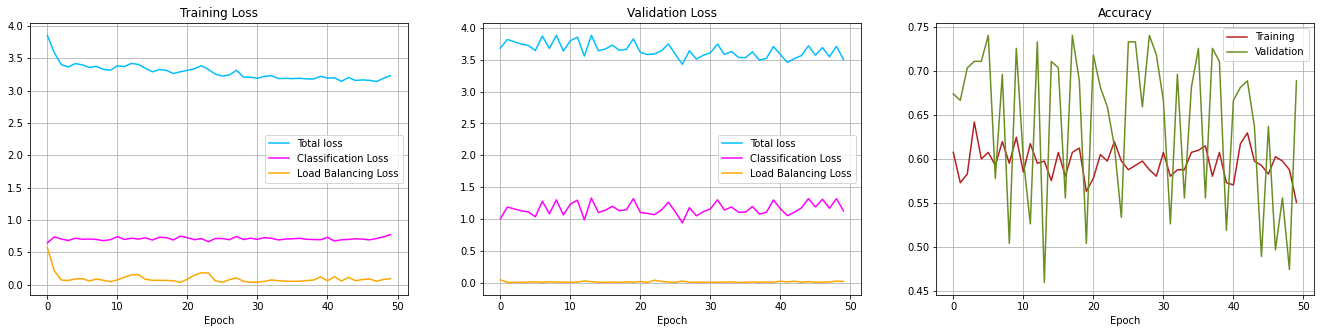

In [ ]:
# make some plots
fig,ax = plt.subplots(1,3, figsize = (23,5))

epochs = np.arange(len(history_early_exit.history['loss']))
ax[0].plot(epochs, history_early_exit.history['loss'], label = 'Total loss', color = 'deepskyblue')
ax[0].plot(epochs, loss_weights[0]*np.array(history_early_exit.history['output_1_loss']), label = 'Classification Loss', color = 'fuchsia')
ax[0].plot(epochs, loss_weights[1]*np.array(history_early_exit.history['output_2_loss']), label = 'Load Balancing Loss', color = 'orange')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Training Loss')
ax[0].legend()
ax[0].grid()
ax[1].plot(epochs, history_early_exit.history['val_loss'], label = 'Total loss', color = 'deepskyblue')
ax[1].plot(epochs, loss_weights[0]*np.array(history_early_exit.history['val_output_1_loss']), label = 'Classification Loss', color = 'fuchsia')
ax[1].plot(epochs, loss_weights[1]*np.array(history_early_exit.history['val_output_2_loss']), label = 'Load Balancing Loss', color = 'orange')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Validation Loss')
ax[1].legend()
ax[1].grid()
ax[2].plot(epochs, history_early_exit.history['output_1_sparse_categorical_accuracy'], label = 'Training', color = 'firebrick')
ax[2].plot(epochs, history_early_exit.history['val_output_1_sparse_categorical_accuracy'], label = 'Validation', color = 'olivedrab')
ax[2].set_xlabel('Epoch')
ax[2].set_title('Accuracy')
ax[2].legend()
ax[2].grid()
plt.show()

5/5 [==============================] - 0s 50ms/step


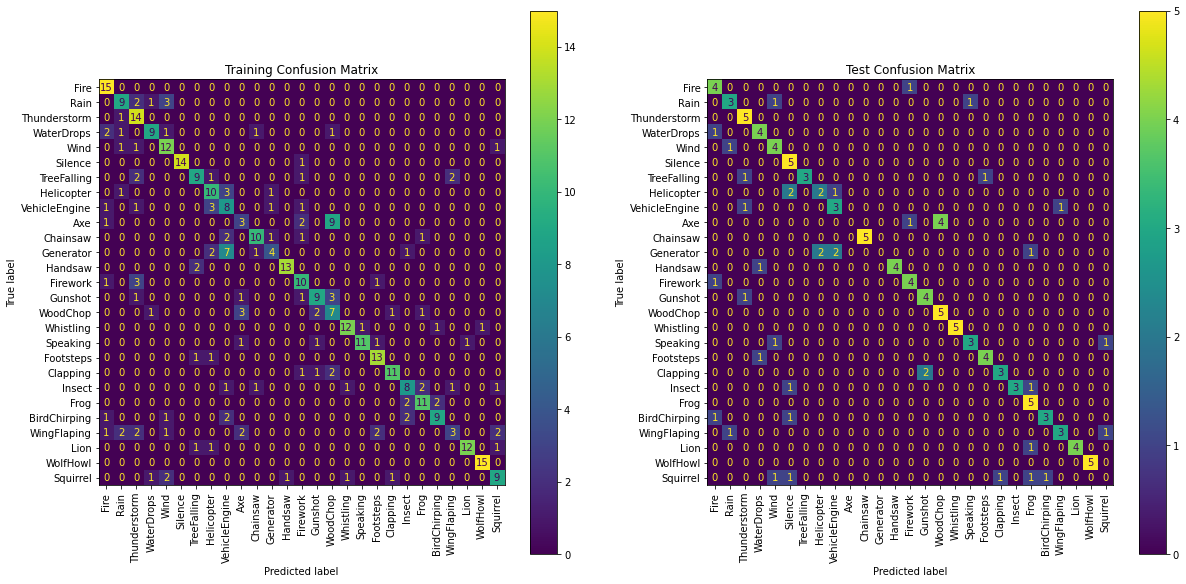

In [ ]:
X_test, y_test = test_data.unbatch().batch(3000).get_single_element()
X_train, y_train = val_data.unbatch().batch(3000).get_single_element()

fig,ax = plt.subplots(1,2, figsize = (20,10))

actual = y_train
predicted = tf.argmax(early_exit_model_inference.predict(X_train), -1)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, ax = ax[0])
ax[0].set_xticklabels(labels, rotation = 90)
ax[0].set_yticklabels(labels, rotation = 0)
ax[0].set_title('Training Confusion Matrix')


actual = y_test
predicted = tf.argmax(early_exit_model_inference.predict(X_test), -1)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, ax = ax[1])
ax[1].set_xticklabels(labels, rotation = 90)
ax[1].set_yticklabels(labels, rotation = 0)
ax[1].set_title('Test Confusion Matrix')


plt.show()

In [ ]:
train_loss, train_acc = early_exit_model_inference.evaluate(val_data)
val_loss, val_acc = early_exit_model_inference.evaluate(test_data)


print(f'Training loss is {train_loss:.2f}\nValidation loss is {val_loss:.2f}\nTrain accuracy is {train_acc:.2f}\nTest accuracy is {val_acc:.2f}')

5/5 [==============================] - 0s 53ms/step - loss: 4.6151 - sparse_categorical_accuracy: 0.6889
Training loss is 4.60
Validation loss is 4.62
Train accuracy is 0.67
Test accuracy is 0.69


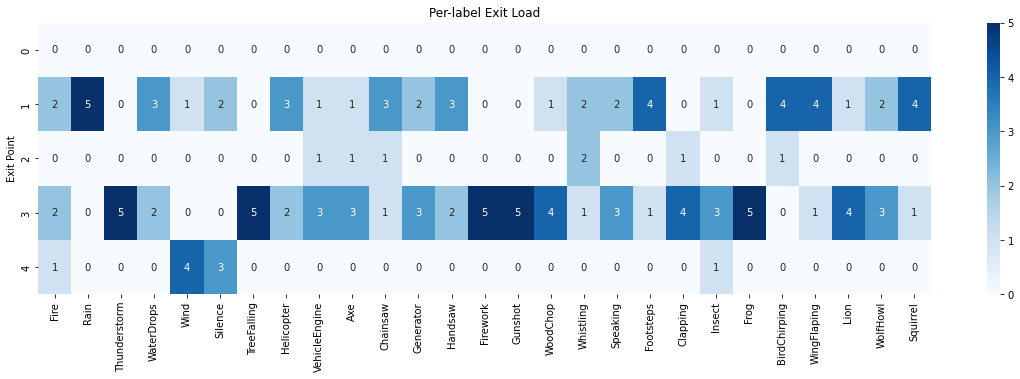

In [ ]:
X, y = test_data.unbatch().batch(3000).get_single_element()
exits = early_exit_model.choose_exits(X).numpy()

exit_load_matrix = np.zeros((early_exit_model.num_exits, early_exit_model.num_classes), dtype = int)
np.add.at(exit_load_matrix, (exits, y.numpy()), 1)

fig,ax = plt.subplots(figsize = (20,5))
sns.heatmap(exit_load_matrix, annot=True, ax = ax, vmin = 0, vmax = len(y)//27, xticklabels = labels, cmap = 'Blues')
ax.set_ylabel('Exit Point')
ax.set_title('Per-label Exit Load')
plt.show()

5/5 [==============================] - 0s 50ms/step


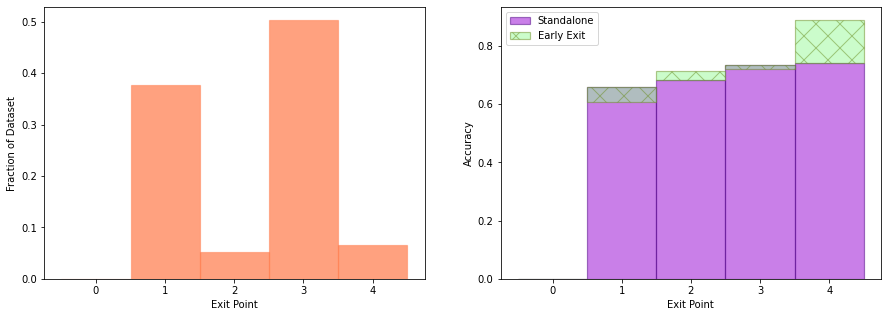

In [ ]:
X, y = test_data.unbatch().batch(3000).get_single_element()
exits = early_exit_model.choose_exits(X).numpy()

predicted = tf.argmax(early_exit_model_inference.predict(X), -1)
standalone_accuracies = [exit0_acc, exit1_acc, exit2_acc, exit3_acc, exit4_acc]
accuracies = np.zeros((early_exit_model.num_exits))

for i in range(len(accuracies)):
  where_exit = (exits == i)
  if np.any(where_exit):
    accuracies[i] = tf.reduce_sum(tf.cast(y[where_exit] == predicted[where_exit], 'int64'))/where_exit.sum()


fig,ax = plt.subplots(1,2,figsize = (15,5))

ax[0].hist(exits, density = True, bins = np.arange(early_exit_model.num_exits+1)-0.5, align = 'mid', color = 'orangered', alpha = 0.5, edgecolor='coral', linewidth=1.2)
ax[0].set_xlabel('Exit Point')
ax[0].set_ylabel('Fraction of Dataset')


# remove zero samples exits
standalone_accuracies = standalone_accuracies * (np.histogram(exits, density = True, bins = np.arange(early_exit_model.num_exits+1)-0.5)[0] > 0)
ax[1].bar(np.arange(early_exit_model.num_exits), standalone_accuracies, width = 1, color = 'darkviolet', alpha = 0.5, edgecolor='indigo', linewidth=1.2, label = 'Standalone')
ax[1].bar(np.arange(early_exit_model.num_exits), accuracies-standalone_accuracies, bottom = standalone_accuracies, width = 1, color = 'palegreen', alpha = 0.5, edgecolor='olivedrab', linewidth=1.2, label = 'Early Exit', hatch='x')
ax[1].set_xlabel('Exit Point')
ax[1].set_ylabel('Accuracy')
ax[1].legend()



plt.show()

In [ ]:
val_acc_exit4 = exit4_model.evaluate(test_data)[1]

# estimate the cost of each exit starting from the number of parameters in each of the early exit models
costs = np.array(list(map(lambda y: sum(map(lambda x: np.prod(x.shape), y.weights)), [exit0_model, exit1_model, exit2_model, exit3_model, exit4_model])))
# cost for the organizer
organizer_cost = np.array(list(map(lambda y: sum(map(lambda x: np.prod(x.shape), y.weights)), [early_exit_model.organizer])))
# cost of the full model
full_model_cost = np.array(list(map(lambda y: sum(map(lambda x: np.prod(x.shape), y.weights)), [exit4_model])))

# add the organizer cost to each exit
costs += organizer_cost

# compute the total cost for the current instance of testing
total_cost = 0
for i in range(early_exit_model.num_exits):
  total_cost += costs[i]*(exits == i).sum()

# normalize by the number of samples and the full model cost
total_cost /= len(exits) * full_model_cost


print(f'The computational cost is (roughly) about {int(total_cost*100)}% of the cost needed to run the network without early exits, with an accuracy drop of {val_acc_exit4-val_acc}.')

5/5 [==============================] - 0s 64ms/step - loss: 1.8262 - sparse_categorical_accuracy: 0.7407
The computational cost is (roughly) about 43% of the cost needed to run the network without early exits, with an accuracy drop of 0.05185180902481079.


As we can see from the plots, the accuracy (both in training and testing) is very noisy, probably due to the randomicity introduced by the differentiable sampling mechanism. The training and validation losses don't show significant variations, indicating that, most probably, the Organizer was not trained succesfully, and that the high accuracy was achieved (almost) only thanks to the already high accuracy in each exit.

In the confusion matrices we can see again the leitmotif of this work: the Axe and the WoodChop classes are very similar and get easily confused.

From the histograms we can see that mainly exits 1 and 3 were used, so the load balancing term did not help much in the training process. The accuracy decreased for these exits, while exit 1 and 4 showed a slight improvement (indicating that the training procedure had an impact somehow).

We cannot tell much looking at the per-label exit load (probably a bigger number of test samples would help here too).

Finally, the overall accuracy lowered significantly by about $5\%$; in return, we had a reduction of $57\%$ (gross estimation, computed starting from the number of parameters in each exit) in the computational cost of the network.

Overall, this training process helped increase significantly the accuracy of the network (as expected), but the exit organizer turned out really hard to train properly. Various attempts were made, but the training process remained highly unstable, so a different method for training should be designed.
The following could be a possible solution:
* assign an "easeness of prediction" score to each training point for each exit (this could be done, for example, by tracking the epochs during training in which the data point started to be correctly identified);
* using this new information, each data point could be labelled with a fixed exit, creating a new dataset;
* the exit organizer could now be trained as a simple classification problem on this new dataset (thus eliminating the problem of the hard choice in training, which is probably one of the causes of the instability).

### Exercise 3 (5 points): Load balancing regularization

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 4.5/6). For a mark of 4.5/6 or higher, an additional point can also be recovered during the exam.**

**To recap**: if you submitted the mid-term homework, implement only Exercises 1 and 2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1, 2, and 3 for a total of *15 points*.

For this exercise, you are asked to implement an additional **regularization term** as follows:

1.   If you followed variant 2a, add a regularization term that will balance the number of elements exiting at each early exit (e.g., a KL divergence w.r.t. an uniform distribution).
2.   If you followed variant 2b, add a regularization term that will balance the amount of tokens (or inputs) that each expert received (e.g., a KL divergence w.r.t. to an uniform distribution).

You have freedom here to follow the ideas from the slides or other ideas you may find in the literature.


✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the regularization term you implemented.*

**TODO**: add description (1-2 paragraphs).

In [ ]:
# TODO: add code here. Train again the model with the new regularization loss.

✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the load for each expert when training). Explain them in code or in text, equivalently.*

In [ ]:
# TODO: Add results here (anything appropriate is okay).

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

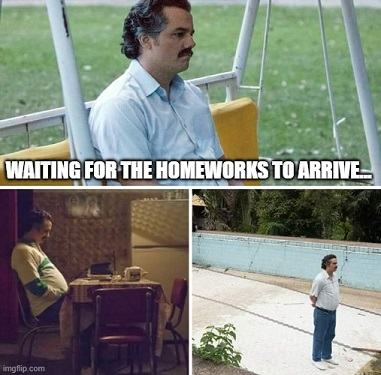